In [1]:
import random

from PIL import Image
import cv2

import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover.datasets import *
from keyrover.ml import get_device
from keyrover import imshow, show_images
from keyrover.vision import *

In [2]:
device = get_device()
device

'mps'

In [3]:
image_paths = get_dataset_paths()
len(image_paths)

2004

In [4]:
mean, std = get_dataset_norm_params(version=3)
mean, std

(array([0.26772413, 0.28418145, 0.28728417]),
 array([0.24711585, 0.24890053, 0.25881228]))

In [5]:
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.8, 0.1)

SIZE = (480, 640)

train_dataset = BinaryKeyboardSegmentationDataset(train_paths, size=SIZE)
valid_dataset = BinaryKeyboardSegmentationDataset(valid_paths, size=SIZE)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, size=SIZE)

len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/1403 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

(1403, 200, 401)

In [6]:
train_dataset.set_transforms([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    # transforms.RandomErasing(p=0.5),
])

train_dataset.set_augmentations([
    # transforms.RandomChannelPermutation(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

test_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

755 (3, 480, 640)


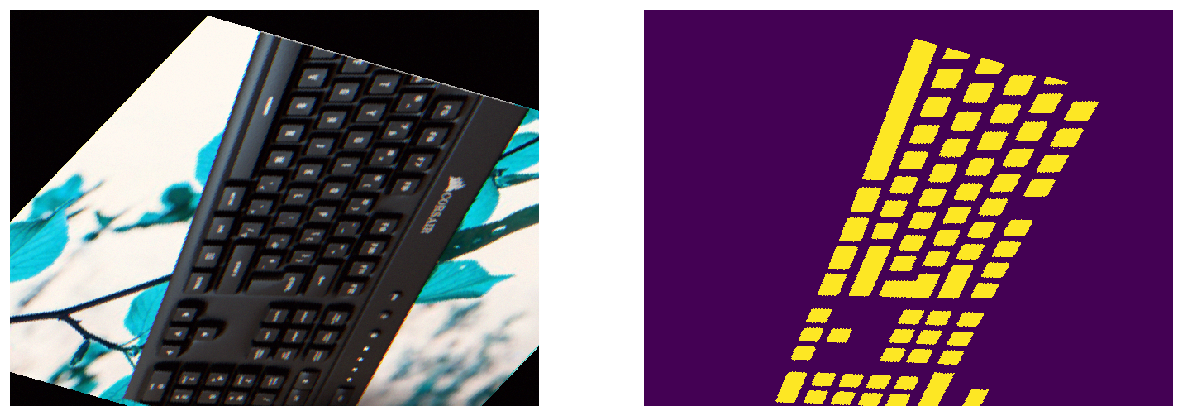

In [7]:
i = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[i]

print(i, tuple(img.shape))
imshow(img, mask, figsize=(15, 30))

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": True}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

In [9]:
img, mask = next(iter(train_dataloader))
img.dtype, mask.dtype

(torch.float32, torch.bool)

In [10]:
import segmentation_models_pytorch as smp


class BinarySegmentationModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()

        self.model = smp.create_model(arch, encoder_name, in_channels=in_channels, classes=out_classes, **kwargs)
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_fn = smp.losses.JaccardLoss(smp.losses.BINARY_MODE)

        self.learning_rate = LEARNING_RATE
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def forward(self, image):
        return self.model(image)

    def _step(self, batch, stage):
        if wandb.run is not None and trainer.global_step == 0:
            wandb.define_metric(f"{stage}_loss", summary="min")

        image, truth = batch
        prediction = self.forward(image)

        loss = self.loss_fn(prediction, truth.int())
        self.log(f"{stage}_loss", loss)
        return loss

        # prob_mask = logits_mask.sigmoid()
        # pred_mask = (prob_mask > 0.5).float()

        # True/False positives/negatives
        # tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        # return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=(self.lr or self.learning_rate))

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=BATCH_SIZE * EPOCHS, eta_min=1e-5)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 5}}

In [ ]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

In [ ]:
ARCH = "unet"
BACKBONE = "timm-regnetx_002"

LEARNING_RATE = 2e-4

wandb.finish()
model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1, encoder_weights="imagenet")
model

In [ ]:
summarize(model)

In [ ]:
EPOCHS = 100

PROFILE = False
profiler = "advanced" if PROFILE else None

logger = WandbLogger(project="mrover-keyboard-region-segmentation")
# logger.watch(model, log="all", log_freq=len(train_dataloader))

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00",
                     callbacks=[checkpoint_callback], profiler=profiler)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
checkpoint = torch.load("mrover-keyboard-region-segmentation/1gf02ro3/checkpoints/epoch=57-step=1160.ckpt",
                        weights_only=True)
model.load_state_dict(checkpoint["state_dict"])

In [ ]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")

In [11]:
ARCH = "unetplusplus"
BACKBONE = "resnet18"
name = "jumping-darkness-67"

LEARNING_RATE = None

model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1)
model.load_state_dict(torch.load(f"models/binary_segmentation/{name}-{ARCH}-{BACKBONE}-v3.pt", weights_only=True))
model.eval()

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


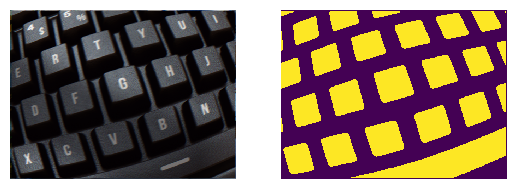

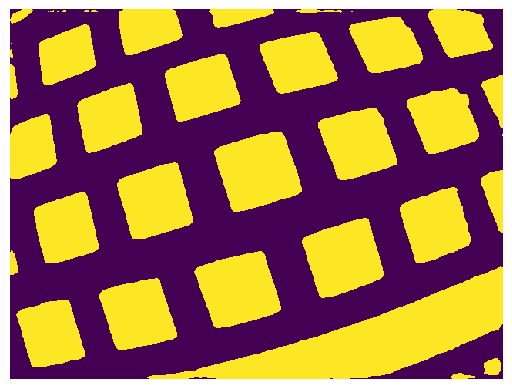

In [12]:
img, mask = test_dataset[random.randint(0, len(test_dataset) - 1)]
pred = model(img.cpu().unsqueeze(0)).detach().numpy()[0][0]

imshow(img, mask)
imshow((pred > 1).astype("uint8"))

In [13]:
model.to("mps")

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


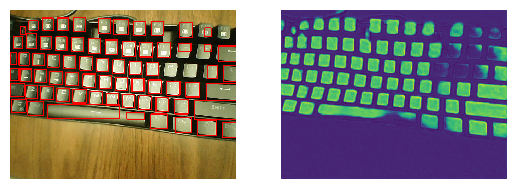

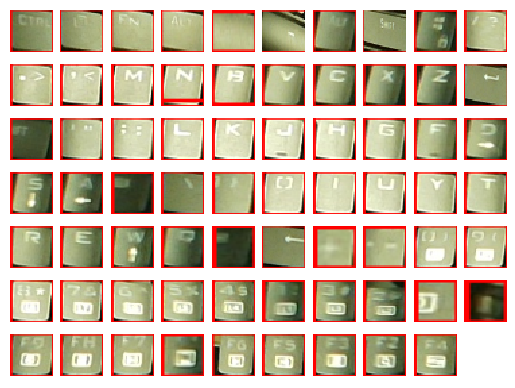

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [41]:
from torchvision.transforms import v2 as transforms
import numpy as np

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

i = 1
img = Image.open(f"datasets/test/{i}.jpg")
pred = model(transform(img).unsqueeze(0).to("mps")).detach()

pred = pred.cpu().numpy()[0][0]
mask = (pred > 0).astype("uint8")

img = np.array(img)
keys = []

for x, y, w, h in extract_rects(mask):
    if w * h < 300:
        continue
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    crop = img[y:y + h, x:x + w]
    crop = cv2.resize(crop, (32, 32))
    keys.append(crop)

imshow(img, pred)
show_images(keys)